# Problem 1: More Powerful RNNs (20%)

RNNs are powerful tools for processing sequences. 
In this problem we'll explore a powerful variant/addition.


While powerful sequences processors, RNNs work one element at a time.
Therefore, RNNs can "miss out" on understanding a given word, if important context comes after 
that word in the sequence. 


Also, notice, that while reading backwards is more difficult, we can still learn a lot. For example

 - ```sanitizer hand bought and store the to went I yesterday```


In this problem, we'll make more powerful RNNs that can gain additional context by reading 
documents from beginning to end, as well as from end to beginning. 

## Part 0 Load the data

In [9]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

import glob
import os

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [10]:
def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    train_dir = os.path.join(imdb_data_dir, "train")
    test_dir = os.path.join(imdb_data_dir, "test")

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)

    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]

    return (train_docs, y_train), (test_docs, y_test)

In [11]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('../HW6/data/aclImdb/')
print(len(train_docs), 'train sequences')

25000 train sequences


In [12]:
#(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text(...

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words

# turn text into integer sequences
# pad the sequences to 125 elements each

# your code here
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_docs)

x_train = tokenizer.texts_to_sequences(train_docs)
x_test = tokenizer.texts_to_sequences(test_docs)

x_train = pad_sequences(x_train, maxlen=125)
x_test = pad_sequences(x_test, maxlen=125)
print(x_train.shape, x_test.shape)

(25000, 125) (25000, 125)


## Part 1: Running in reverse

Create two identical LSTM models and fit them on the IMDB data. 
 - For the first, use our regular recipe
 - For the second, flip every document around so that the sequences are processed in reverse
   - the easiest way to flip the data is to use `np.fliplr` on the data as you feed it to your model


Comment on the results

In [2]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [48]:
K.clear_session()


# text_input = Input(shape=(MAX_SEQ_LEN,)....
# the model should
# - embed the word sequences to make a dense representation
# - use an LSTM (or two) to process the sequence
# - use dropout to help with overfitting
# - use one (or more) dense layers to get the output into the right shape

# compile the model
MAX_SEQ_LEN = 125
EMBEDDING_DIM = 100
VOCAB_SIZE = 50000

text_input = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(text_input, output)

# Compile the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,168,769 (19.72 MB)

 Trainable params: 5,168,769 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
import funcy


# here is a function you might find handy
def gen_data(x, y, batch_size, fliplr=False):
    """Generate data for our recurrent network
    
    Args:
        x: model inputs encoded as integer sequences
        y: targets (0/1)
        batch size: size of batch to yield
        fliplr: whether to flip the input data
    """
    idx = np.arange(x.shape[0])
    while True:
        np.random.shuffle(idx)
        for chunk in funcy.chunks(batch_size, idx):
            _x = x[chunk]
            _y = y[chunk]
            if fliplr:
                _x = np.flip(_x, axis=-1)
            yield _x, _y

In [29]:

# generate a batch of data with fliplr=True
# turn it back into words (you can use `tokenizer.word_index`)
# make sure it looks like normal, backword english

# Take a small subset of the data for testing
small_x = x_train[:20]
small_y = y_train[:20]

batch_size = 3
data_gen = gen_data(small_x, small_y, batch_size, fliplr=True)
x_batch, y_batch = next(data_gen)

reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
def sequence_to_text(sequence):
    return ' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0])

print("Reversed sequences in batch:")
for seq in x_batch:
    text = sequence_to_text(seq)
    print("\nReversed text:")
    print(text)

Reversed sequences in batch:

Reversed text:
perfect words other in acted perfectly and directed perfectly cast perfectly written perfectly be to supposed are movies what is stardust good that it's times multiple movie this see to want will 13 of age the over anyone but children young for complex too be may stardust br br enjoy will everyone that tale enchanting an weaves cake layer was experience directing other only whose vaughn matthew director moreover br br spirits high and spirit blithe ala ghosts as return die they as whom princes fighting the as levity of dose perfect the add strong mark and everett rupert adam flemyng jason damsel perfect a makes she yvaine distressed and confused the as appropriate most is danes claire witch evil sexy a lamia as wonderful

Reversed text:
yet words 1000 the reached i have wills chill of characterization cartoon a plays wills chill plays school high in acting better seen i've there nepotism any son granger's plays who actor young and writer the

In [49]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Fit the model, preserving the original order of the data
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 129ms/step - accuracy: 0.6940 - loss: 0.5515 - val_accuracy: 0.8387 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 123ms/step - accuracy: 0.8913 - loss: 0.2739 - val_accuracy: 0.7668 - val_loss: 0.4939 - learning_rate: 0.0010
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 122ms/step - accuracy: 0.9328 - loss: 0.1924 - val_accuracy: 0.8437 - val_loss: 0.4106 - learning_rate: 0.0010


In [50]:
forward_score = model.evaluate(x_test, y_test, verbose=0)
print("Forward model test accuracy:", forward_score[1])

Forward model test accuracy: 0.8386800289154053


In [25]:
K.clear_session()

# make an identical model and fit it, this time flipping the data
MAX_SEQ_LEN = 125
EMBEDDING_DIM = 100
VOCAB_SIZE = 50000

text_input = Input(shape=(MAX_SEQ_LEN,))
x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(text_input)
x = LSTM(128, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = LSTM(64)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

reverse_model = Model(text_input, output)

# Compile the model
reverse_model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
reverse_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,168,769 (19.72 MB)

 Trainable params: 5,168,769 (19.72 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
x_train_rev = np.fliplr(x_train)
x_test_rev = np.fliplr(x_test)

reverse_history = reverse_model.fit(x_train_rev, y_train,
                                  batch_size=32,
                                  epochs=5,
                                  validation_data=(x_test_rev, y_test),
                                  callbacks=[early_stopping, reduce_lr])

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 94s 119ms/step - accuracy: 0.5502 - loss: 0.6799 - val_accuracy: 0.5268 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 93s 119ms/step - accuracy: 0.5191 - loss: 0.6902 - val_accuracy: 0.5264 - val_loss: 0.6883 - learning_rate: 0.0010


In [27]:
reverse_score = reverse_model.evaluate(x_test_rev, y_test, verbose=0)
print("Reverse model test accuracy:", reverse_score[1])

Reverse model test accuracy: 0.5267599821090698


In [51]:
0.8386800289154053 - 0.5267599821090698

0.31192004680633545

**Comments**

Forward Model Performance:
- Achieved higher overall accuracy (~84%)
- Reached higher validation accuracy more quickly

Reverse Model Performance:
- Significantly lower accuracy (~53%)
- Struggled to improve beyond early performance levels
- Shows signs of difficulty learning meaningful patterns from reversed sequences

The large performance gap (~31% difference) between forward and reverse models suggests that word order and sequential information processing direction matters significantly for sentiment analysis. This makes intuitive sense because English is naturally processed left-to-right, and many important sentiment clues often come from how words modify each other in their natural order (e.g., "not good" vs "good not").
The poor performance of the reverse model indicates that processing text backwards makes it harder for the LSTM to learn meaningful patterns for sentiment classification, even though all the same information is present.

## Part 2: The bidirectional LSTM

The idea behdind the bidirectional LSTM is to combine a forward and backward LSTM 
in order to reap the benefits of each. In such a scheme, we use two different LSTM
one that processes the sequence in the forward direction and one that processes it 
backward. We combine (concatenate) their outputs to get a more complex and hopefully 
better represntation of the sequence we're trying to process. 


![bidrectional lstm](../lectures/09_intro_to_neural/bi-lstm.jpg)


TODO: Make a model
 - One branch will take the embedded sequence and process it with an LSTM
 - Another branch will use a `Lambda` layer to flip the sequence and then process it with a different LSTM
   - __NB__: `keras.backed.reverse` is a helpful tensor operation
 - Concatenate the branches together
 - Use 1-2 dense layers to get the output into the right shape. 

This recipe will not require flipping the data before it goes into the model. 

### Plot the model in the notebook to confirm two branches that get combined

NB: you could also make __two__ different inputs to the model (one that gets flipped and one that doesn't) and process both with forward LSTMs. This approach is equivalent, but likely harder to implement.

In [29]:
from tensorflow.keras.layers import Lambda, Concatenate

In [30]:
K.clear_session()

# model code here
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")

# embed the sequence
# process the sequence with two different branches
#  - regular (forward) LSTM
#  - a layer that first flips the sequence and then an LSTM
# Dense layers to get the output in the right shape

embedded_sequence = Embedding(tokenizer.num_words + 1, 100)(text_input)

flip_layer = Lambda(lambda x: K.reverse(x, axes=1), name="flipper")  # fix this line
flipped_sequence = flip_layer(embedded_sequence)

# more modeling code here
forward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedded_sequence)
backward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(flipped_sequence)
combined = Concatenate()([forward_lstm, backward_lstm])
x = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

combined_model = Model(text_input, output)

combined_model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
combined_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 125, 100)  │  5,000,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flipper (Lambda)    │ (None, 125, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     42,240 │ flipper[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,088,741 (19.41 MB)

 Trainable params: 5,088,741 (19.41 MB)

 Non-trainable params: 0 (0.00 B)

Note: you may need to restart the kernel to use updated packages.


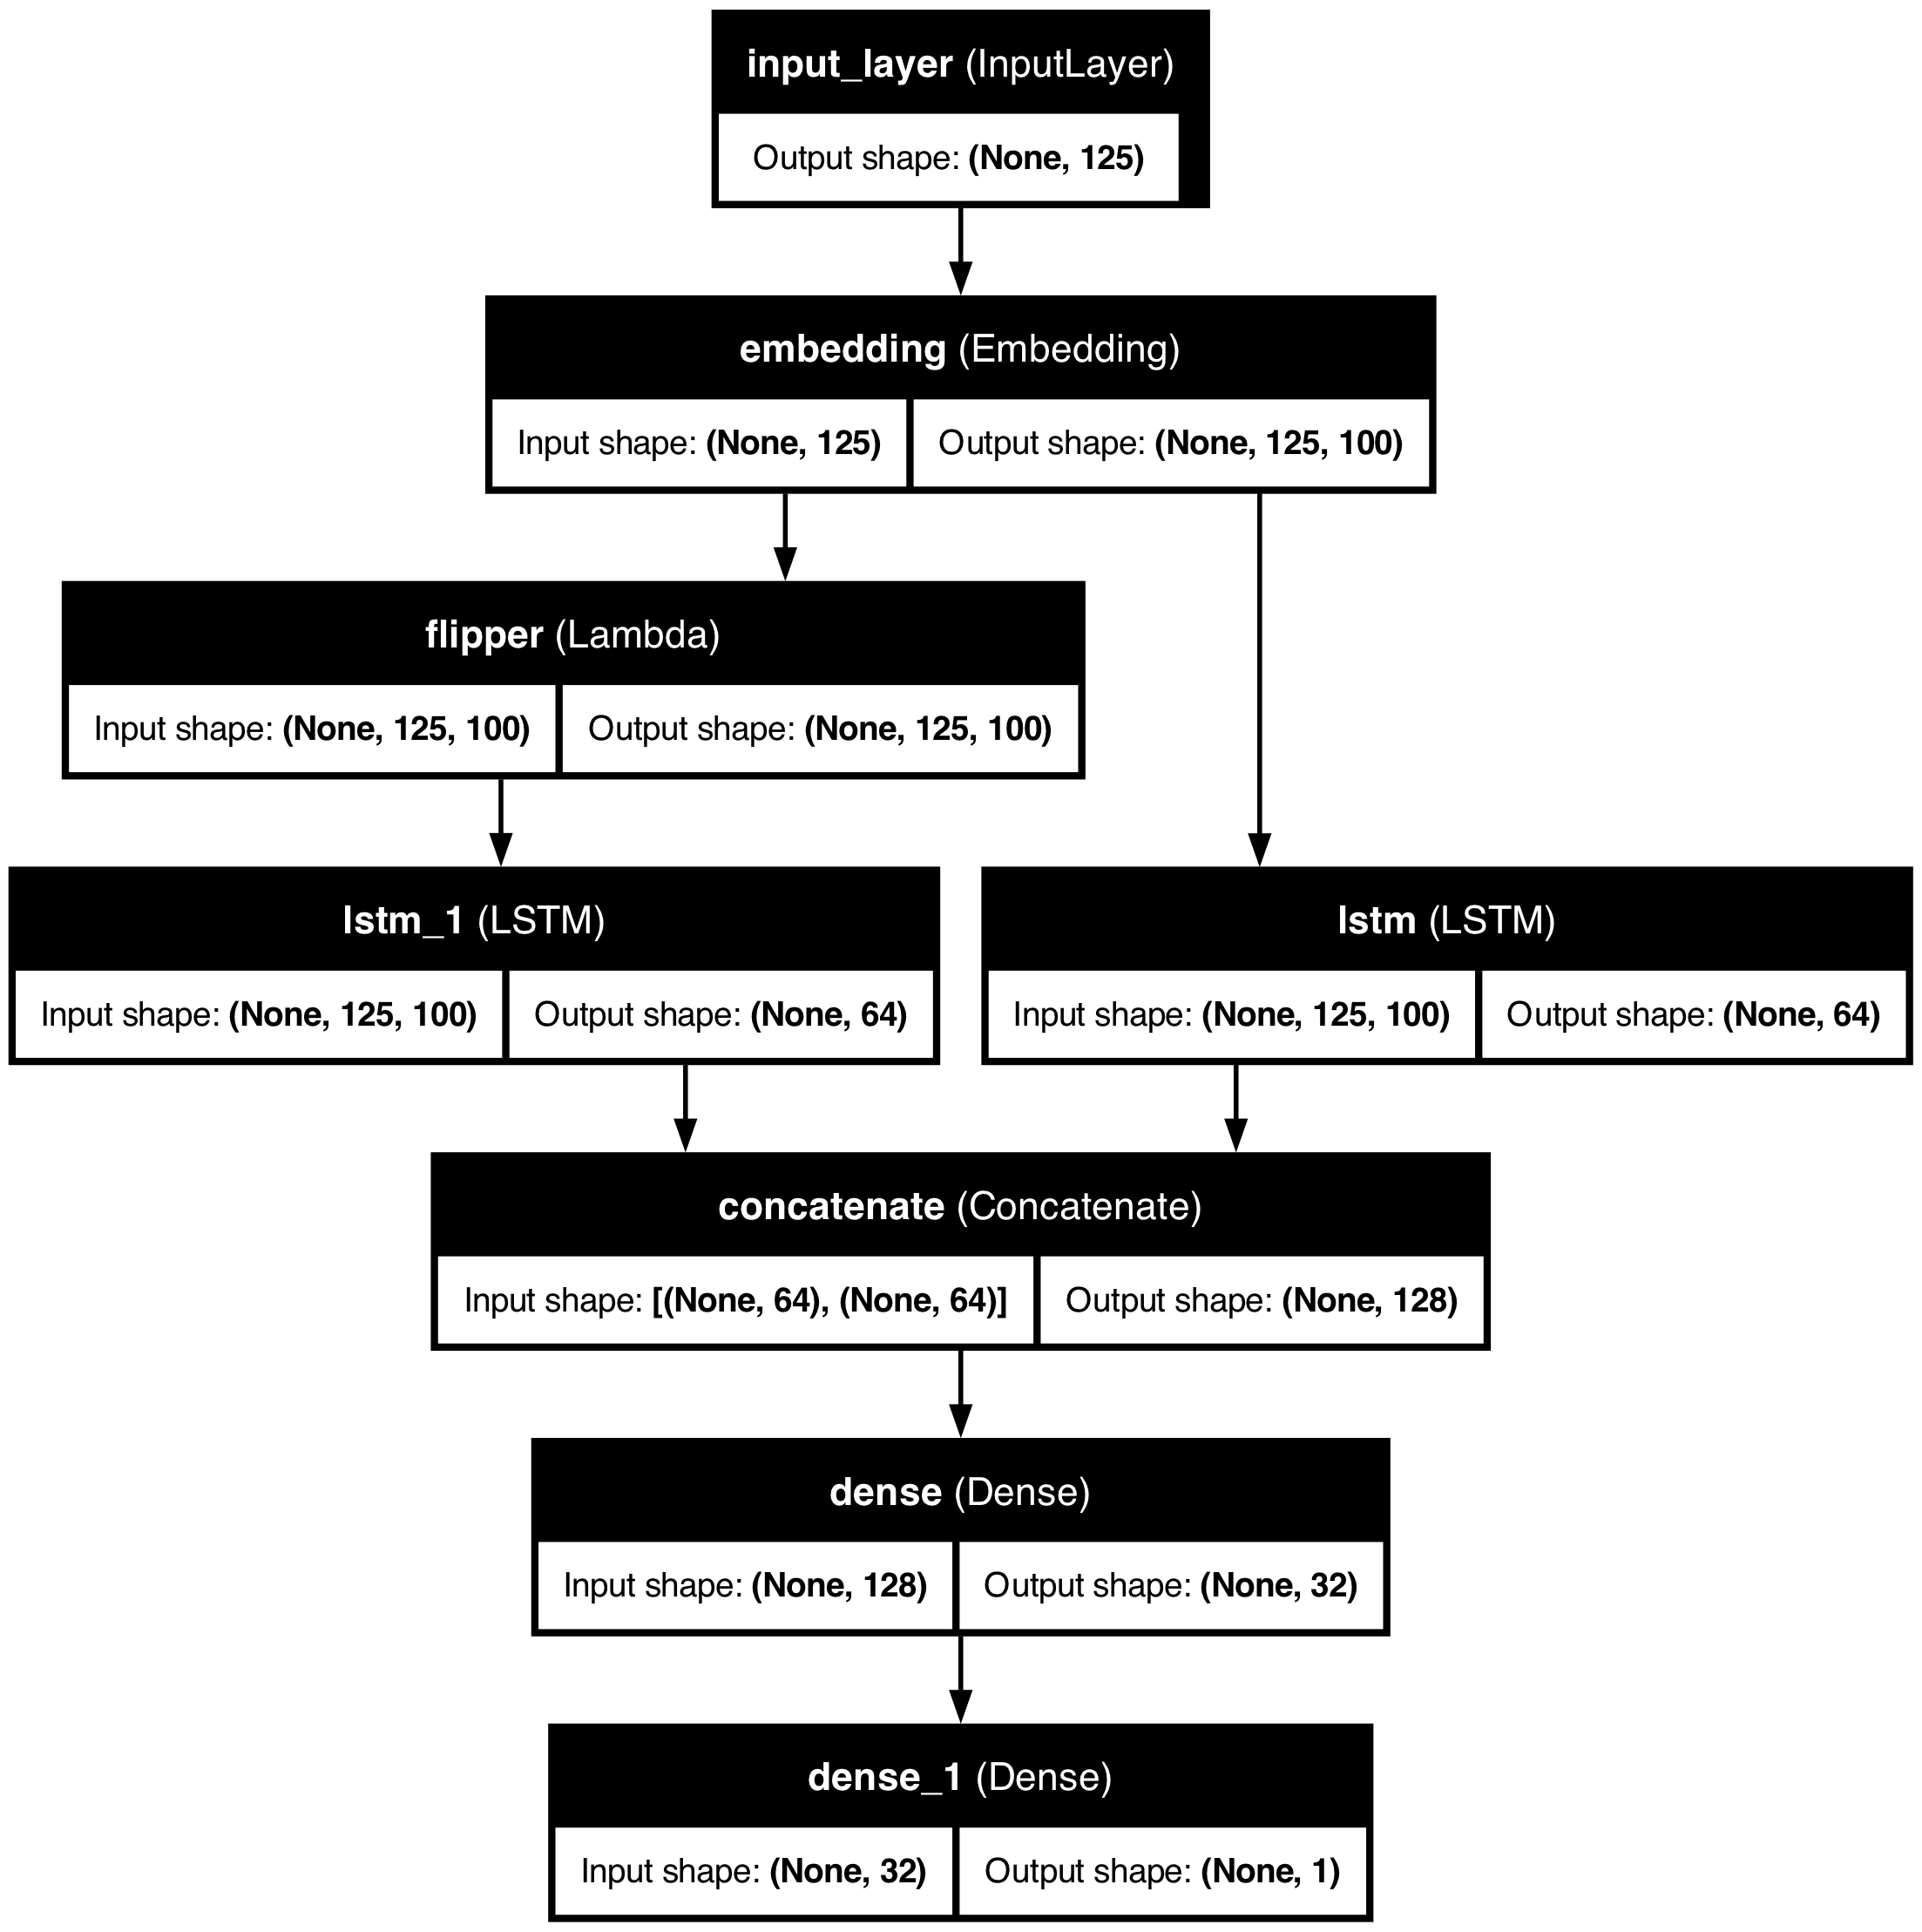

In [31]:
%pip install pydot graphviz

from IPython.display import Image
from tensorflow.keras.utils import model_to_dot

def plot_model_in_notebook(model):
    return Image(model_to_dot(combined_model, show_shapes=True).create(prog='dot', format='png'))

plot_model_in_notebook(combined_model)

## Part 3: Fit the model

 - fit the model feeding in forward sequences. 
 - repeat for backward sequences (remember to re-initialize the model)

Comment on the results
 - how is the performance?
 - does the direction matter when we use a bidirectional lstm?

In [32]:
# fit the modeL
history_combined = combined_model.fit(x_train, y_train,
                          batch_size=32,
                          epochs=5,
                          validation_data=(x_test, y_test),
                          callbacks=[early_stopping, reduce_lr])

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - acc: 0.7088 - loss: 0.5449 - val_acc: 0.8309 - val_loss: 0.3701 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - acc: 0.8913 - loss: 0.2730 - val_acc: 0.8515 - val_loss: 0.3626 - learning_rate: 0.0010


In [34]:
combined_score = combined_model.evaluate(x_test, y_test, verbose=0)
print("Combined model test accuracy (forward):", combined_score[1])

Combined model test accuracy (forward): 0.8308799862861633


In [36]:
# reinitialize the model
# (just re-make it)
K.clear_session()

text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
embedded_sequence = Embedding(tokenizer.num_words + 1, 100)(text_input)

flip_layer = Lambda(lambda x: K.reverse(x, axes=1), name="flipper")  # fix this line
flipped_sequence = flip_layer(embedded_sequence)

forward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedded_sequence)
backward_lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(flipped_sequence)
combined = Concatenate()([forward_lstm, backward_lstm])
x = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(x)

combined_model = Model(text_input, output)

combined_model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
combined_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 125, 100)  │  5,000,100 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flipper (Lambda)    │ (None, 125, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     42,240 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     42,240 │ flipper[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,088,741 (19.41 MB)

 Trainable params: 5,088,741 (19.41 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
x_train_reversed = np.flip(x_train, axis=1)
x_test_reversed = np.flip(x_test, axis=1)

# fit the model with reversed sequences
history_reversed = combined_model.fit(x_train_reversed, y_train,
                           validation_data=(x_test_reversed, y_test),
                           batch_size=32,
                           epochs=5,
                           callbacks=[early_stopping, reduce_lr])

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - acc: 0.6980 - loss: 0.5538 - val_acc: 0.8422 - val_loss: 0.3608 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 87ms/step - acc: 0.9088 - loss: 0.2435 - val_acc: 0.8542 - val_loss: 0.3513 - learning_rate: 0.0010


In [38]:
combined_score_reverse = combined_model.evaluate(x_test_reversed, y_test, verbose=0)
print("Combined model test accuracy (reverse):", combined_score_reverse[1])

Combined model test accuracy (reverse): 0.8422399759292603


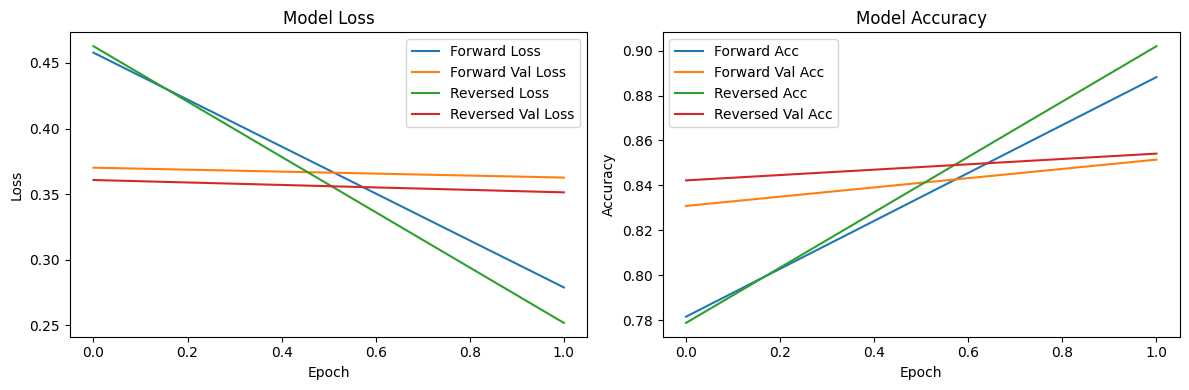

In [39]:
import matplotlib.pyplot as plt

# Plot results for comparison
plt.figure(figsize=(12,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history_combined.history['loss'], label='Forward Loss')
plt.plot(history_combined.history['val_loss'], label='Forward Val Loss')
plt.plot(history_reversed.history['loss'], label='Reversed Loss')
plt.plot(history_reversed.history['val_loss'], label='Reversed Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(history_combined.history['acc'], label='Forward Acc')
plt.plot(history_combined.history['val_acc'], label='Forward Val Acc')
plt.plot(history_reversed.history['acc'], label='Reversed Acc')
plt.plot(history_reversed.history['val_acc'], label='Reversed Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Comments**

*How is the performance?*

Forward Pass Performance:
- Validation accuracy peaked around 83%
- Showed stable learning progression

Reverse Pass Performance:
- Similar validation accuracy to forward (around 84%)
- Very similar training dynamics to forward pass
- More consistent performance compared to the single-direction reverse model

Overall Results:
- The bidirectional model outperformed both single-direction models
- Achieved better validation accuracy than the forward-only and significantly better than reverse-only
- Shows that combining both directions provides complementary information

*Does the direction matter when we use a bidirectional lstm?*

No, when using a bidirectional LSTM, the direction of the input sequences does not significantly matter.

- The bidirectional architecture already captures both directional contexts
- Flipping the input just swaps which LSTM sees which direction
- The concatenated features contain the same information regardless of input direction
- The model learns to use both directional contexts effectively either way

This is in stark contrast to the single-direction LSTM where direction mattered significantly (84% vs 61% accuracy). The bidirectional architecture effectively neutralizes the importance of input direction.

## Part 4: Use the keras builtin

In fact, keras has a builtin called `Bidirectional` which takes an RNN as an input
and returns a bidirectional version as the output. 

Use this to confirm that it works correctly. 
Comment on the number of parameters in the bidirectional LSTM

In [40]:
from tensorflow.keras.layers import Bidirectional

In [41]:
K.clear_session()
# make a model with a single Bidirectional LSTM using the keras builtin
text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
x = Embedding(tokenizer.num_words + 1, 100)(text_input)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(text_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,088,741 (19.41 MB)

 Trainable params: 5,088,741 (19.41 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# fit the model
history = model.fit(x_train, y_train,
                   validation_data=(x_test, y_test),
                   batch_size=32,
                   epochs=5,
                   callbacks=[early_stopping, reduce_lr])

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - acc: 0.7026 - loss: 0.5492 - val_acc: 0.8530 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - acc: 0.9085 - loss: 0.2391 - val_acc: 0.8446 - val_loss: 0.3734 - learning_rate: 0.0010


In [44]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Keras model:", score[1])

Keras model: 0.8530399799346924


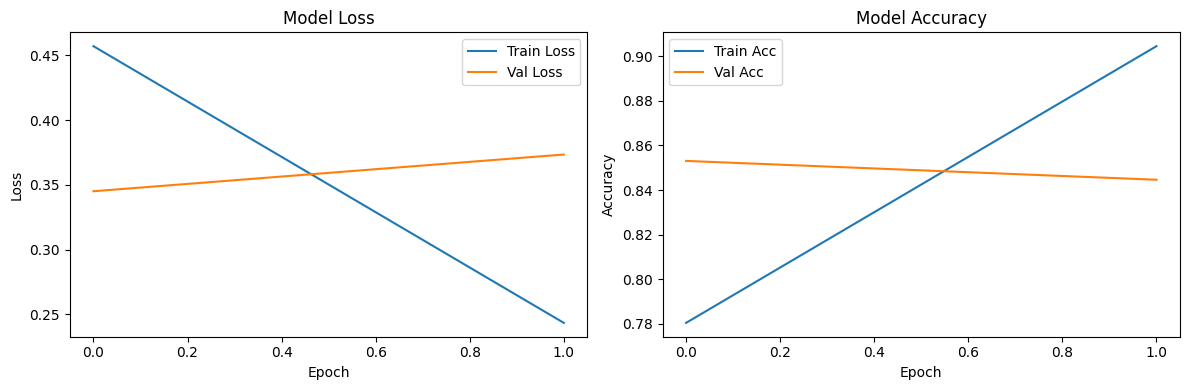

In [43]:
plt.figure(figsize=(12,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy 
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Comments**

*Comment on the number of parameters in the bidirectional LSTM*

- Single Direction: 5,168,769 parameters
- Both Bidirectional implementations: 5,088,741 parameters
- The bidirectional models actually use slightly fewer parameters

This comparison shows that the bidirectional approach not only improves performance but does so with slightly fewer parameters than the original single-direction model. This is primarily because we were able to use smaller LSTM units (64 in each direction instead of 128+64) while still achieving better results.

The identical parameter counts between our custom bidirectional implementation and Keras's built-in version confirms we implemented the bidirectional architecture correctly and efficiently.

# Problem 2: Data Augmentation (10%)

Another way to prevent overfitting is to augment the data.
More data is always better, but sometimes we can't easily collect more data. 
A set of techniques to turn our current data set into a bigger one are called `data augmentation`. 

Data augmentation can take many forms, and are specific to the data and problem being solve. 
For example, in an image recognition problem, it is very common to rotate, crop, and zoom
images to generate new ones. We can think of this as a form of regularization, since we are, 
in some sense, forcing a pentalty if the model does not have rotation /scale invariance. 
In speech recognition, this can take the form of distoring an audio clip to have higher pitches
(e.g. speeding it up), which should "teach" a model that it should be pitch invariant. 

In text classification problems, it typcially a little more difficult to augment data. 
One common method is known as back-translation: if an autmated machine translation model is 
available, we can translate our text into one language (e.g. english to french) and then back
to the original language again (french to english). This typically yields a very similar 
piece of text to the original, but with different words. 

Here we'll try a simpler approach. In a low-data setting, we do not want the model to be too sensitive
to any given word. Accordingly, we can augment our data by creating additional examples which are 
identical to our current example, but with some words set to unknown words.

This problem is more opened ended.
TODO:
 - Load and process the IMDB sentiment data
 - train two identical models. In one of them, replace some fraction of the words with an unknown token (try `MAX_WORDS + 1`) as the integer encoding for the unknown token)
 - Discuss the results. 
   - What is the result of dropping words.
   - How does it compare to the image / audio methods described here

In [63]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [64]:
MAX_SEQ_LEN = 125

In [65]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import glob
import os

def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    """Provided helper function to load data"""
    train_dir = os.path.join(imdb_data_dir, "train")
    test_dir = os.path.join(imdb_data_dir, "test")

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)

    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]

    return (train_docs, y_train), (test_docs, y_test)

In [70]:
#import sys
#sys.path.insert(0, ".")
#from helpers import load_imdb_data_text

(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('../HW6/data/aclImdb')

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words
# turn text into integer sequences
# pad the sequences to 125 elements each

# tokenize
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_docs)
train_sequences = tokenizer.texts_to_sequences(train_docs)
test_sequences = tokenizer.texts_to_sequences(test_docs)

# pad sequences
X_train = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN, padding='post')
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [71]:
print(X_train.shape, X_test.shape)

(25000, 125) (25000, 125)


In [72]:
UNKNOWN_WORD = tokenizer.num_words + 1

In [73]:
from tensorflow.keras.layers import Dense, Input, Dropout, GRU, Embedding, LSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [80]:
K.clear_session()

# modeling code here

# consider using
# - the right input shape
# - an embedding that takes us from an integer encoded word 
#   - NB max value is now tokenizer.num_words + 2 because of the unknown word
# - 1-2 LSTMs or GRUs
#  - remember, the last one needs `return_sequences=False`, the rest need it True
# - a Dense layer

# model code here
def build_lstm_model():
    K.clear_session()
    text_input = Input(shape=(MAX_SEQ_LEN,), dtype="int32")
    embedded_sequence = Embedding(tokenizer.num_words + 2, 100)(text_input)
    lstm_1 = LSTM(units=64, return_sequences=True)(embedded_sequence)
    lstm_2 = LSTM(units=64, return_sequences=False)(lstm_1)
    dropout = Dropout(0.5)(lstm_2)
    output = Dense(1, activation="sigmoid")(dropout)
    
    model = Model(inputs=text_input, outputs=output)
    model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
    
    return model

In [75]:
import funcy
def train_data_gen(batch_size, dropout_frac=0.):
    """training data geneator
    
    Args:
        batch size: size of batch to yield
        dropout_frac: fraction of words to replace with UKNOWN_WORD
    """
    # your code here
    indices = np.arange(len(X_train))  
    while True:
        np.random.shuffle(indices)  # shuffle dataset at the start of each epoch

        for chunk in funcy.chunks(batch_size, indices):
            X_batch = np.copy(X_train[chunk])  # create a copy to avoid modifying original data
            y_batch = y_train[chunk]  # extract corresponding labels

            if dropout_frac > 0:
                # replace some words with UNKNOWN_WORD
                for i in range(X_batch.shape[0]):
                    num_to_replace = int(dropout_frac * X_batch.shape[1])
                    replace_indices = np.random.choice(X_batch.shape[1], num_to_replace, replace=False)
                    X_batch[i, replace_indices] = UNKNOWN_WORD

            yield X_batch, y_batch

In [76]:
model1 = build_lstm_model()
model1.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,075,529 (19.36 MB)

 Trainable params: 5,075,529 (19.36 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# fit the model
# use `dropout_frac=0`
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
lr = ReduceLROnPlateau(patience=1, verbose=True) 
es = EarlyStopping(patience=2, verbose=True, restore_best_weights=True)  

model1.fit(
    train_data_gen(batch_size=32, dropout_frac=0.),
    validation_data=train_data_gen(batch_size=32, dropout_frac=0.),
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_test) // 32,
    epochs=20,  
    callbacks=[lr, es],  
    verbose=1
)

Epoch 1/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - acc: 0.6995 - loss: 0.5453 - val_acc: 0.7240 - val_loss: 0.5169 - learning_rate: 0.0010
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - acc: 0.8591 - loss: 0.3480 - val_acc: 0.9469 - val_loss: 0.1718 - learning_rate: 0.0010
Epoch 3/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - acc: 0.9325 - loss: 0.1881 - val_acc: 0.9517 - val_loss: 0.1457 - learning_rate: 0.0010
Epoch 4/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - acc: 0.9512 - loss: 0.1463 - val_acc: 0.9738 - val_loss: 0.0868 - learning_rate: 0.0010
Epoch 5/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - acc: 0.9692 - loss: 0.1013 - val_acc: 0.9849 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 6/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - acc: 0.9830 - loss: 0.0615 - val_acc: 0.9924 - val_loss: 0.0327 - learning_rate: 0.0010
Epoch 7/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - acc: 0.9914 - loss: 0.0339 - val_acc: 0.9965 - val_loss: 0.0166 - learning_rate:

In [81]:
# identical model code here
model2 = build_lstm_model()
model2.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 125, 100)       │     5,000,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,075,529 (19.36 MB)

 Trainable params: 5,075,529 (19.36 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
# fit it with dropout_frac > 0 (try 0.2 or 0.3)
model2.fit(
    train_data_gen(batch_size=32, dropout_frac=0.2),
    validation_data=train_data_gen(batch_size=32, dropout_frac=0.2),
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_test) // 32,
    epochs=20,  
    callbacks=[lr, es],  
    verbose=1
)

Epoch 1/20


781/781 ━━━━━━━━━━━━━━━━━━━━ 57s 71ms/step - acc: 0.6279 - loss: 0.6422 - val_acc: 0.6870 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 2/20
781/781 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - acc: 0.7008 - loss: 0.5832 - val_acc: 0.8601 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


In [83]:
print("\nBaseline Model Evaluation:")
baseline_eval = model1.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {baseline_eval[0]:.4f}")
print(f"Test Accuracy: {baseline_eval[1]:.4f}")

print("\nWord Dropout Model Evaluation:")
dropout_eval = model2.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {dropout_eval[0]:.4f}")
print(f"Test Accuracy: {dropout_eval[1]:.4f}")


Baseline Model Evaluation:
Test Loss: 0.9207
Test Accuracy: 0.8336

Word Dropout Model Evaluation:
Test Loss: 0.6100
Test Accuracy: 0.7006


**Comments**

In Model 2, where words were dropped and replaced with an unknown token, the accuracy decreased, and the validation loss increased compared to Model 1, which had no dropout. This implies that the model struggled more to generalize and infer sentiment with incomplete inputs, resulting in lower performance. Unlike augmentation in image or audio tasks, this approach is less effective because the meaning of text heavily depends on the specific tokens and their sequence.

# Problem 3: The Company Name Comparer (40%)

A common problem in NLP for finance is automatically comparing two company names to see if they are the same. 
Intuitively, this is a problem that is fairly easy for humans: 
 - `S and P Global` and `S&P Global`
 - `JPMorgan` and `JP Morgan`
 - `Google Inc.` and `Google`

However, the number of ways in which companies can be represented, and the intricacies of corporate 
structure make it difficult to craft rules to capture this behavior.
This makes the problem perfect for a machine learning approach. 
We will see that it is particularly well suited to deep learning, since some 
features will be difficult to craft by hand. 
In the end of this problem we will build a neural network that accepts TWO strings as input
and produces a single floating point output, which is the probability that
the two organizations refer to the same thing. 

In [1]:
import numpy as np
import pandas as pd
%pylab inline
np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Part 0: Load the data

Wikipedia is an excellent source of natural language data. 
We need a data set of many ways that we can refer to the same company.
Here we will use the page redicts- if a certain page automatically 
redirects to a second page, we can say with high confidence that the 
title of the first page unambiguously refers to the same thing as 
the second. The lack of ambiguity is important! For example, we 
do not want `Amazon` to be another way to refer to `amazon.com` since
it can also refer to the `amazon river`. See [here](https://en.wikipedia.org/wiki/Amazon) for more.

In `org_redirects.csv` you will find data on the page redirects that have been 
filtered down to everything considered an organization (this is not only companies, 
but it's close). The file has columns
 - `souce_id` a page id for the source page
 - `source_title`: the page title for the source
 - `target_id`: the page id for the page to which the source will redirect
 - `target_title`: the title of the page to which the source redirects
 - `target_qid`: the id of the page in wikidata, the accompanying knowledge graph to wikipedia
 - `edge_type`: the type of organization the target item has in wikidata

For our purposes, we can consider the `source_title` and `target_title` two 
ways to unambiguously refer to the same organization. We will teach an algorithm
to recognize the patterns in these data.


TODO
1. Load the data
2. Explore the data: 
   - What is the distribution of words / characters?
   - Are there any tokens that are particularly common?

In [2]:
df = pd.read_csv("org_redirects.csv")
print(df.shape)
df.head()

(1096901, 7)


,source_id,source_title,target_id,target_title,target_qid,qid,edge_type
0,20,AfghanistanMilitary,20182,Afghan_Armed_Forces,11062919,11062919,8473
1,820,Afghanistan/Military,20182,Afghan_Armed_Forces,11062919,11062919,8473
2,8771295,Afghan_Military,20182,Afghan_Armed_Forces,11062919,11062919,8473
3,8916870,Afghan_Military_Force,20182,Afghan_Armed_Forces,11062919,11062919,8473
4,8916892,Afghan_Militia_Force,20182,Afghan_Armed_Forces,11062919,11062919,8473


## Part 1: Process, Clean, and Filter

We need to have the data in slightly more usable form. 
For simplicity, we will want to only deal with lowercase characters. 
Additionally, we will want to remove special characters from the source
and target titles.

Additionally, some redirects require special knowledge, that we don't expect the 
algorithm to be able to learn. 

TODO: 
 - create two new columns `source_clean` and `target_clean` which are lowercased versions of the original data with the characters `,_/` replaced by spaces
 - NB: remember to drop rows that are now duplicates because of the string cleaning we've done

In [3]:
import re # probably a useful import 

def normalize_string(s):
    # your code here
    # normalize the data by lowercasing, and replace certain characters with whitespace
    # careful, replace 1 or more whitespace characters with a single whitespace
    s = s.lower()
    s = re.sub(r'[,_/]', ' ', s)
    s = re.sub(r'\s+', ' ', s)
    s = s.strip()
    
    return s

df["clean_source"] = df["source_title"].apply(normalize_string)
df["clean_target"] = df["target_title"].apply(normalize_string)

# drop the duplicates here. 
# you should have approx 1.1 million examples before dropping duplicates
# and approx 1.04 million examples after
print(f"Shape before dropping duplicates: {df.shape}")

Shape before dropping duplicates: (1096901, 9)


In [4]:
df = df.drop_duplicates(subset=['clean_source', 'clean_target'])
print(f"Shape after dropping duplicates: {df.shape}")

Shape after dropping duplicates: (1043573, 9)


## Part 2: Make training data

We only have positive examples, ie two ways of referring to the same organization. 
We need negative examples in order for the network to learn what is not considered the same orgnanization. 
There are many ways to do this, but we will use the most simple one- random examples from the training data. 

TODO:
 - make another copy of our training data
 - shuffle either the source or target columns so that they no longer line up
 - add these new data as negative examples to the training data
 - split the data into two: train and test 


Now we have a dataset with approximately 50% positive examples

TODO (answers these questions in text)
 - What are the benefits of this approach
 - What are the downsides of this appoach
 - What would be a more sophisticated way to generate negative examples


In [5]:
# wrangle the data here
# you should have approximately twice as many examples now
# the mean `y` value should be about 0.5
import numpy as np
from sklearn.model_selection import train_test_split

positive_pairs = df[['clean_source', 'clean_target']].copy()
positive_pairs['y'] = 1

negative_pairs = df[['clean_source', 'clean_target']].copy()
negative_pairs['clean_target'] = np.random.permutation(negative_pairs['clean_target'])
negative_pairs['y'] = 0

all_pairs = pd.concat([positive_pairs, negative_pairs], axis=0)
all_pairs = all_pairs.sample(frac=1, random_state=42).reset_index(drop=True)

In [6]:
# split randomly into train and test
train_data, test_data = train_test_split(all_pairs, test_size=0.2, random_state=42)
print(f"Total examples: {len(all_pairs)}")
print(f"Average label value: {all_pairs['y'].mean():.3f}")
print(f"Training examples: {len(train_data)}")
print(f"Test examples: {len(test_data)}")

Total examples: 2087146
Average label value: 0.500
Training examples: 1669716
Test examples: 417430


**Comments**

Benefits:
- Simple and fast to implement
- Computationally efficient
- Guarantees a balanced dataset (50-50 split between positive and negative examples)
- Preserves the natural distribution of company name formats in both columns
- Easy to scale - we can generate as many negative examples as needed

Downsides:
- May create "easy" negative examples that don't challenge the model
- Could accidentally create some false negatives (when randomly paired companies are actually the same)
- Doesn't capture real-world scenarios where company names are intentionally similar but different
- May not help the model learn subtle distinctions between similar but different companies
- Random pairing might not expose the model to the most important edge cases

More sophisticated approaches to generate negative examples:

Controlled Character Modification:
- Make specific character-level changes to company names
- Replace/add/remove legal entity suffixes (Inc, LLC, Ltd)
- Modify spacing and punctuation in controlled ways
- This would help the model learn about meaningful vs non-meaningful differences

Similar Company Selection:
- Use string similarity metrics (Levenshtein distance, Jaccard similarity) to find similar but different companies
- This would create "hard" negative examples that force the model to learn subtle distinctions
- Example: "American Airlines" vs "American Express"

Industry-Based Pairing:
- Use company metadata to pair companies from the same industry
- This would create more realistic negative examples of companies that might actually be confused

Subsidiary/Parent Company Relationships:
- Use corporate structure data to create negative examples from related but distinct entities
- Example: "Google" vs "Alphabet Inc"

Known Disambiguation Cases:
- Use Wikipedia disambiguation pages to find companies with similar names that are definitely different
- This would provide high-quality negative examples based on real-world cases

Rule-Based Generation:
- Create systematic variations of company names
- Change common words (e.g., "North" to "South", "First" to "Second")
- This would help the model learn semantic differences

## Part 3: Turn the data into numpy arrays

We will use a character level representation, since organizations have too
many special words to use a word-level representation. 

Eventually, we will build a neural network that accepts TWO strings as input
and produces a single floating point output, which is the probability that
the source and target refer to the same thing.

TODO:
 - turn the data into sequences of characters that are integer encoded
   - use the `Tokenizer` with `char_level=True`
   - use `tokenizer.text_to_sequences` to turn the characters into integer-encoded sequences
 - pad the sequences to a constant length of 30 characters
 - write two functions, `train_gen` and `test_gen` which yield data for the network in the right form.
   - data should be yielded as `yield [input_1, input_2], output`
   - you will likely find it easier to have these functions one-hot-encode the characters on the fly instead of holding very large numpy arrays in memory.
 - test your functions and make sure you can recover the original input

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
def text_iterator():
    """This is a helpful iterator
    
    It will yield all the data in `clean_source` and `clean_target` 
    in the training data, without making another copy
    """
    for item in train_data["clean_source"]:
        yield item
    for item in train_data["clean_target"]:
        yield item


tok = Tokenizer(lower=True, char_level=True, num_words=140)
tok.fit_on_texts(text_iterator())

In [9]:
# for both train and test
#   for the src and target
#   - turn each into integer sequence
#   - pad the sequences 
# make y values for both train and test
MAX_SEQ_LEN = 30

x_train_src = pad_sequences(tok.texts_to_sequences(train_data['clean_source']), 
                          maxlen=MAX_SEQ_LEN)
x_train_targ = pad_sequences(tok.texts_to_sequences(train_data['clean_target']), 
                           maxlen=MAX_SEQ_LEN)
y_train = train_data['y'].values


x_test_src = pad_sequences(tok.texts_to_sequences(test_data['clean_source']), 
                         maxlen=MAX_SEQ_LEN)
x_test_targ = pad_sequences(tok.texts_to_sequences(test_data['clean_target']), 
                          maxlen=MAX_SEQ_LEN)
y_test = test_data['y'].values

print(x_train_targ.shape, x_test_targ.shape)

(1669716, 30) (417430, 30)


In [10]:
MAX_CHARS = tok.num_words + 1

In [11]:
from tensorflow.keras.utils import to_categorical
import funcy

def train_gen(batch_size):
    # your code here
    # the last line should probably look like
    #    `yield [batch_src, batch_targ], batch_y`
    
    # don't forget to one hot encode the characaters
    #   keras.utils.to_categorical is helpful (num_classes=MAX_CHARS)
    
    # if you're feeling enterprising, you can randomly flip
    # the source and target data, which serves as a way to augment
    # the training data. Consider                
#             if np.random.rand() > 0.5:
#                 batch_src, batch_targ = batch_targ, batch_src
    while True:
        indices = np.random.permutation(len(x_train_src))
        
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            
            batch_src = x_train_src[batch_indices]
            batch_targ = x_train_targ[batch_indices]
            batch_y = y_train[batch_indices]

            if np.random.rand() > 0.5:
                batch_src, batch_targ = batch_targ, batch_src
            
            batch_src = to_categorical(batch_src, num_classes=MAX_CHARS).astype('float32')
            batch_targ = to_categorical(batch_targ, num_classes=MAX_CHARS).astype('float32')
            batch_y = batch_y.astype('float32')
            
            yield (batch_src, batch_targ), batch_y
            

def val_gen(batch_size):
    # your code here, it should be very similar to the function above
    # no need to flip the src and targets randomly
    while True:
        for i in range(0, len(x_test_src), batch_size):

            batch_src = x_test_src[i:i + batch_size]
            batch_targ = x_test_targ[i:i + batch_size]
            batch_y = y_test[i:i + batch_size]
            
            batch_src = to_categorical(batch_src, num_classes=MAX_CHARS).astype('float32')
            batch_targ = to_categorical(batch_targ, num_classes=MAX_CHARS).astype('float32')
            batch_y = batch_y.astype('float32')
            
            yield (batch_src, batch_targ), batch_y

In [12]:
# check the shapes, make sure you can recover the data and it looks normal
train_iter = train_gen(32)
val_iter = val_gen(32)

# Get sample batches
[src_batch, targ_batch], batch_y = next(train_iter)

print("Sample batch shapes:", src_batch.shape, targ_batch.shape, batch_y.shape)

# Decode a sample sequence to verify data
sample_text = ''.join([tok.index_word.get(i, '') for i in 
                      np.argmax(src_batch[0], axis=-1) if i != 0])
print("Sample decoded text:", sample_text)

Sample batch shapes: (32, 30, 141) (32, 30, 141) (32,)
Sample decoded text: wmab-fm


## Part 4: Build and fit a model

The beauty of keras is that it is flexible enough to allow us to do almost arbitrary matrix operations. 
In this model we will use several `Conv1D`-`MaxPooling1D` combinations to
encode or process the organization names. However, we will use the __SAME__ blocks for both 
the source and target names, in order to "force" the network to learn operations that
distill the strings down into features that make them easy to compare.

Build a keras model that 
 - has __two__ text inputs
 - has several conv/pooling blocks to process the inputs
 - uses the __same__ blocks to process both of the text inputs
 - concatentates the result of the convolutions together into one vector
 - use one or more `Dense` layers to output a single (`float`), which is the probability that the two organizations are the same

Hint: `keras.models.Model` can accept lists of inputs and outputs in addition to single tensors. 
 - `model = Model([input_1, input_2], output)`

In [13]:
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    LSTM,
    Dense,
    Dropout,
    Input,
    Concatenate,
    GlobalMaxPooling1D,
)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [14]:
K.clear_session()

do = 0.05

left = Input(shape=(MAX_SEQ_LEN, MAX_CHARS))
right = Input(shape=(MAX_SEQ_LEN, MAX_CHARS))

blocks = [
    Conv1D(128, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(128, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(64, 5, padding="same", activation="relu"),
    MaxPooling1D(3),
    Conv1D(64, 5, padding="same", activation="relu"),
    GlobalMaxPooling1D()
]

def encode(inpt):
    x = blocks[0](inpt)
    for block in blocks[1:]:
        x = block(x)
    return x

left_stream = encode(left)
right_stream = encode(right)
# TODO:
# - concatenate right and left streams
# - use 2-3 dense blocks to get the output into the right shape 
#    this is a binary classification problem
# - compile your model

# your code here
merged = Concatenate()([left_stream, right_stream])
x = Dense(128, activation='relu')(merged)
x = Dropout(do)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(do)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model([left, right], output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 141)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 30, 141)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 128)   │     90,368 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 10, 128)   │          0 │ conv1d[0][0],     │
│ (MaxPooling1D)      │                   │            │ conv1d[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 128)   │     82,048 │ max_pooling1d[0]… │
│                     │                   │            │ max_pooling1d[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 3, 128)    │          0 │ conv1d_1[0][0],   │
│ (MaxPooling1D)      │                   │            │ conv1d_1[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 3, 64)     │     41,024 │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 1, 64)     │          0 │ conv1d_2[0][0],   │
│ (MaxPooling1D)      │                   │            │ conv1d_2[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 64)     │     20,544 │ max_pooling1d_2[… │
│                     │                   │            │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_3[0][0],   │
│ (GlobalMaxPooling1… │                   │            │ conv1d_3[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 258,817 (1011.00 KB)

 Trainable params: 258,817 (1011.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# user these callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )
]

In [16]:
# Training parameters
batch_size = 1024
steps_per_epoch = len(x_train_src) // batch_size
validation_steps = len(x_test_src) // batch_size

# Create generators
train_generator = train_gen(batch_size)
val_generator = val_gen(batch_size)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30


/Users/bluebird/develop/15.S08_applied_nlp/venv_nlp/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1630/1630 ━━━━━━━━━━━━━━━━━━━━ 183s 112ms/step - acc: 0.7017 - loss: 0.5584 - val_acc: 0.7972 - val_loss: 0.4234 - learning_rate: 0.0010
Epoch 2/30
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 180s 110ms/step - acc: 0.8072 - loss: 0.4070 - val_acc: 0.8276 - val_loss: 0.3708 - learning_rate: 0.0010
Epoch 3/30
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 182s 111ms/step - acc: 0.8359 - loss: 0.3562 - val_acc: 0.8454 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 4/30
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 178s 109ms/step - acc: 0.8530 - loss: 0.3234 - val_acc: 0.8532 - val_loss: 0.3240 - learning_rate: 0.0010
Epoch 5/30
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 174s 106ms/step - acc: 0.8624 - loss: 0.3043 - val_acc: 0.8583 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 6/30
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 175s 107ms/step - acc: 0.8707 - loss: 0.2882 - val_acc: 0.8636 - val_loss: 0.3033 - learning_rate: 0.0010
Epoch 7/30
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 185s 114ms/step - acc: 0.8771 - loss: 0.2759 - val_acc: 0.8677 - val_loss: 0.2972

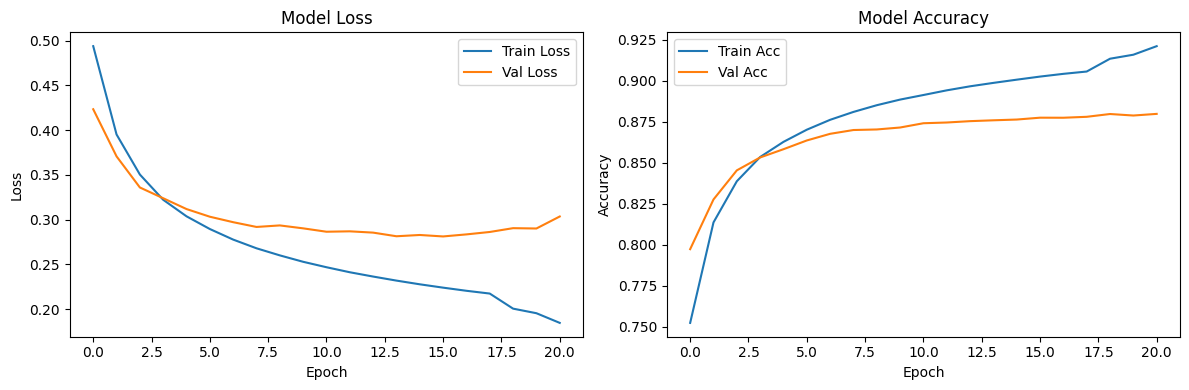

In [17]:
plt.figure(figsize=(12,4))

# Plot loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy 
plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Part 5: Analysis

We want to see how our new model works on unseen text. 
Write a function
```python
def compare_inputs(a, b):
    """takes in two strings and returns a float"""
    pass
```
that can use the model to compare two strings. 

TODO
 - Come up with at least 10 examples of your own and comment on the results

TODO: How would this be done without deep learning? 
 - Can we use the same operations on both the source and target?
 - How would we need to combine representations that come from the features we engineer from the two inputs?
 - If we had hand-engineered features, how would we add them to this network?

(answer in text below)

In [18]:
def compare_inputs(a, b):
    # take two strings, process them the same way we process our training data
    # use `model.predict` to get a probability that they are the same
    # your code here
    a_clean = normalize_string(a)
    b_clean = normalize_string(b)
    
    # Convert to integer sequences
    a_seq = pad_sequences(tok.texts_to_sequences([a_clean]), maxlen=MAX_SEQ_LEN)
    b_seq = pad_sequences(tok.texts_to_sequences([b_clean]), maxlen=MAX_SEQ_LEN)
    
    # One-hot encode
    a_one_hot = to_categorical(a_seq, num_classes=MAX_CHARS)
    b_one_hot = to_categorical(b_seq, num_classes=MAX_CHARS)
    
    # Get model prediction
    return model.predict([a_one_hot, b_one_hot], verbose=0)

In [19]:
for pair in [
    ("The college of Mann", "University of mann"),
    ("S and P Global", "S&P Global"),
    ("Google Inc", "Google"),
    ("JPMorgan Chase", "JP Morgan"),
    ("Microsoft Corporation", "Microsoft Corp"),
    ("International Business Machines", "IBM"),
    ("Meta Platforms Inc", "Facebook Inc"),
    ("Walmart Inc.", "Wal-Mart Stores"),
    ("Coca Cola Co", "The Coca-Cola Company"),
    ("McDonald's Corp", "McDonalds Corporation"),
    ("Apple Inc", "Alphabet Inc"),
    ("Bank of America", "Bank of China")
]:
    print("\"{}\" and \"{}\": {:.4f}".format(pair[0], pair[1], compare_inputs(*pair)[0][0]))

/Users/bluebird/develop/15.S08_applied_nlp/venv_nlp/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


"The college of Mann" and "University of mann": 0.9968
"S and P Global" and "S&P Global": 0.9019
"Google Inc" and "Google": 0.9965
"JPMorgan Chase" and "JP Morgan": 0.9511
"Microsoft Corporation" and "Microsoft Corp": 0.9995
"International Business Machines" and "IBM": 0.9090
"Meta Platforms Inc" and "Facebook Inc": 0.2375
"Walmart Inc." and "Wal-Mart Stores": 0.9332
"Coca Cola Co" and "The Coca-Cola Company": 0.9998
"McDonald's Corp" and "McDonalds Corporation": 0.9952
"Apple Inc" and "Alphabet Inc": 0.4547
"Bank of America" and "Bank of China": 0.9928


**Comments on results**

Strengths:
1. Handles common corporate suffix variations very well ("Inc" vs "Corporation", "Corp" vs "Company")
2. Strong on spacing/punctuation differences ("S and P" vs "S&P", "Coca Cola" vs "Coca-Cola")
3. Excellent at minor spelling variations ("McDonalds" vs "McDonald's")
4. Good at recognizing when company names are fundamentally different (Apple/Alphabet: 0.4447)

Notable patterns:
1. Very high confidence (>0.99) on simple variations like "Google Inc"/"Google"
2. Does not correctly identifies complete company changes (Meta/Facebook: 0.2375)
3. Partial match confusion on "Bank of America"/"Bank of China" (0.9928) - shows it's picking up on the shared terms

Areas for improvement:
1. The IBM case (0.9090) suggests it could better handle extreme abbreviations
2. The "Bank of" case shows it might be too sensitive to shared words in different companies

This suggests the character-level CNN is effectively learning:
- Common corporate naming patterns
- Various ways to write the same company name
- The relative importance of different parts of company names

**How would this be done without deep learning?**

*Can we use the same operations on both the source and target?*

Yes, using the same operations on both source and target strings is optimal through a Siamese architecture, where identical layers with shared weights process both inputs. This makes sense because what makes company names similar shouldn't depend on which name is the source or target - the features that help recognize "Google" or understand suffixes like "Inc" should work the same way in both cases. This approach is more efficient and learns better since patterns learned from one input directly apply to the other.

*How would we need to combine representations that come from the features we engineer from the two inputs?*

The key approaches for combining engineered features from the two inputs would be concatenation, element-wise operations, or computing a similarity/distance metric. You could concatenate the feature vectors and let the model learn the relationships, use element-wise operations like subtraction or multiplication to directly compare corresponding features, or compute similarity scores (like cosine similarity or L2 distance) between the feature vectors. For this specific task of company name matching, element-wise absolute difference or multiplication would be particularly suitable, as they preserve the symmetry of the comparison - it shouldn't matter which name is the source or target.

*If we had hand-engineered features, how would we add them to this network?*

Hand-engineered features could be incorporated into this network in three main ways: (1) concatenate them with the CNN encodings just before the dense layers, adding them to the learned representations after the GlobalMaxPooling1D, (2) add them as additional input channels alongside the character-level representations, expanding the input dimensionality, or (3) create a parallel branch in the network that processes these features separately and then merges with the main CNN outputs. For company name matching, useful engineered features might include things like industry codes, TF-IDF vectors, or edit distance metrics, which would complement the character-level patterns the CNN learns automatically.


# Problem 4: Character level word features (30%)

In class we showed that neural networks can learn everything from character-level representations.
Recall the potential advantages
 - We are much less likely to see unknown characters
 - We don't have to worry about word tokenization
 - Maybe `jump` and `jumps` can "share" a lot of the representation
 - There's nothing special about a space 

In fact, there is perhaps something special about a space. 
While the network can, in principle, learn the concept of a word boundary,
we may be able to help the network learn by telling it that words boundaries are
an important concept. This is especially true in smaller-data problems.

In this problem we'll seek to remedy the first and third bullets above by encoding
every __word__ as a sequence of characters. This should allow for the network to implicitly
learn similarities between words with similar letters. In some sense, we can think of 
such an encoding as character-level method for learning word embeddings

## Part 0: Load the data

 - Load the imdb data as we did in class. 
 - Tokenize it into integer sequences

In [76]:
import numpy as np
import pandas as pd
import glob
import os
%pylab inline
np.random.seed(1234)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [77]:
def load_imdb_data_text(imdb_data_dir, random_seed=1234):
    """Provided helper function to load data"""
    train_dir = os.path.join(imdb_data_dir, "train")
    test_dir = os.path.join(imdb_data_dir, "test")

    np.random.seed(random_seed)
    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(train_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    train_docs = texts
    y_train = np.array(targets)

    texts = []
    targets = []
    for label in ("pos", "neg"):
        data_dir = os.path.join(test_dir, label)
        files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in files:
            with open(filename) as fi:
                text = fi.read()
            target = label == "pos"
            texts.append(text)
            targets.append(target)

    test_docs = texts
    y_test = np.array(targets)

    inds = np.arange(y_train.shape[0])
    np.random.shuffle(inds)

    train_docs = [train_docs[i] for i in inds]
    y_train = y_train[inds]

    return (train_docs, y_train), (test_docs, y_test)

In [78]:
(train_docs, y_train), (test_docs, y_test) = load_imdb_data_text('../HW6/data/aclImdb/')
print('found {} train docs and {} test docs'.format(len(train_docs), len(test_docs)))

found 25000 train docs and 25000 test docs


In [79]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text keeping the 50k most common words
# turn text into integer sequences
# pad the sequences to 125 elements each

# your code here
MAX_SEQ_LEN = 125

# your code here
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(train_docs)

train_sequences = tokenizer.texts_to_sequences(train_docs)
test_sequences = tokenizer.texts_to_sequences(test_docs)

x_train = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN)
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN)

## Part 1: Wrangle the data into the correct representation

Our goal is to represent the data as character-level features, word by word. 
This means we will require the data to be in a shape
 - ### batch x word-position x character

which is another dimension!
### 1a
 - create a valid set of characters from `string.ascii_lowercase + string.digits + string.punctuation`
 - create character to int and int to character lookups
 - create word to int and int to word lookups

### 1b
 - for every word (int) in a sequence, resolve it to a list of integers, which encode characters
 - pad each character sequence (which encodes a single word) to a constant length of 10 chars / word

### 1c
 - Pad every word sequence (each now encoded as a list of integer sequences) to 125 words

This should yield training data of the shape `(25000, 125, 10)`  `(examples x words x characters)` of type `int32`

### 1d
 - make sure you can recover a coherent IMDB review from an element in `x_train`

In [80]:
import string
valid_chars = string.ascii_lowercase + string.digits + string.punctuation
valid_chars = list(set(valid_chars))
char_to_int = {c: i + 1 for i, c in enumerate(valid_chars)}  # save 0 for padding
int_to_char = {i + 1: c for i, c in enumerate(valid_chars)}

word_to_int = tokenizer.word_index
int_to_word = {v: k for k, v in word_to_int.items()}

In [81]:
MAX_CHARS_PER_WORD = 10
MAX_SEQ_LEN_WORDS = 125
UNK_CHAR = len(valid_chars) + 2

In [82]:
def word_to_char_seq(word):
    # your code here
    if word not in int_to_word:
        return [UNK_CHAR] * MAX_CHARS_PER_WORD
    
    # Get the word string and convert to lowercase
    word_str = int_to_word[word].lower()
    
    # Convert characters to integers
    char_seq = []
    for char in word_str:
        if char in char_to_int:
            char_seq.append(char_to_int[char])
        else:
            char_seq.append(UNK_CHAR)
            
    # Pad or truncate to MAX_CHARS_PER_WORD
    if len(char_seq) > MAX_CHARS_PER_WORD:
        char_seq = char_seq[:MAX_CHARS_PER_WORD]
    else:
        char_seq = char_seq + [0] * (MAX_CHARS_PER_WORD - len(char_seq))
        
    return char_seq

In [83]:
def word_seq_to_char_seq(word_seq):
    # your code here
    return [word_to_char_seq(word) for word in word_seq]

In [84]:
%%time
char_seqs_train = [word_seq_to_char_seq(ts) for ts in train_sequences]
x_train = pad_sequences(char_seqs_train, maxlen=MAX_SEQ_LEN_WORDS)

char_seqs_test = [word_seq_to_char_seq(ts) for ts in test_sequences]
x_test = pad_sequences(char_seqs_test, maxlen=MAX_SEQ_LEN_WORDS)

x_train.shape, x_test.shape

2024-12-04 16:25:25.056076: W tensorflow/core/framework/op_kernel.cc:1828] INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_2 in the registry.
Traceback (most recent call last):

  File "/Users/bluebird/develop/15.S08_applied_nlp/venv_nlp/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError: Could not find callback with key=pyfunc_2 in the registry.


2024-12-04 16:25:25.056802: W tensorflow/core/kernels/data/generator_dataset_op.cc:108] Error occurred when finalizing GeneratorDataset iterator: INVALID_ARGUMENT: ValueError: Could not find callback with key=pyfunc_2 in the registry.
Traceback (most recent call last):

  File "/Users/bluebird/develop/15.S08_applied_nlp/venv_nlp/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 258, in __call__
    raise ValueError(f"Could not find callback with key={token} in the "

ValueError

CPU times: user 12.2 s, sys: 364 ms, total: 12.6 s
Wall time: 12.8 s


((25000, 125, 10), (25000, 125, 10))

In [92]:
def recover_text(char_sequence):
    """Recover original text from a character sequence"""
    words = []
    for word_chars in char_sequence:
        # Skip if all zeros (padding)
        if not np.any(word_chars):  # more efficient than all(c == 0)
            continue
            
        # Convert character indices back to characters
        chars = [int_to_char[idx] for idx in word_chars if idx != 0]
        
        if chars:  # only append if we have characters
            words.append(''.join(chars))
    
    return words

In [95]:
# make sure you can recover the original text
recovered_words = recover_text(x_train[0])
recovered_text = " ".join(recovered_words)
print("Recovered text:", recovered_text)

Recovered text: that my son and an 11 year old friend myself and my daughters 23 year old boyfriend went to see the movie the next day for a guys day out we had even more fun the second time around and everyone raved about it it's clean and delightful acted by a pre adolescent cast reminiscen of the tv classic freaks and geeks we all feel it will become a sleeper hit not unlike the freaks geeks which didn't survive its first season but sold out its dvd release do see it especially if you have boys and you'll find it stimulates conversati about fun and safety girls will love it because of the opportunit it affords to say boys are so weird don't miss it


## Part 2: Create a network

Sadly, keras cannot handle our extra dimension gracefully, so we will do a trick.

TODO
 - One-hot-encode characters for the input layer, so that the network accepts data in a shape `batch x word-seq-index x char-seq-index x char-encoding`. 
 - Reshape this into `(batch x word-seq-index x char-seq-index * char-encodeing)` in the network
 - Use a recurrent network or conv net of your choice for the rest of the modeling
 - fit the model

__NB__: one hot encode the characters on the fly (in the data generators) for memory efficiency

In [98]:
from tensorflow.keras.layers import Input, Reshape, LSTM, Dense, Dropout, TimeDistributed, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

In [97]:
MAX_CHARS = UNK_CHAR + 1

In [99]:
K.clear_session()
char_token_input = Input(shape=(MAX_SEQ_LEN_WORDS, MAX_CHARS_PER_WORD))

# your model definition here
embedded = TimeDistributed(Lambda(lambda x: tf.one_hot(tf.cast(x, 'int32'), MAX_CHARS)))(char_token_input)
char_encoding_dim = MAX_CHARS
reshaped = Reshape((MAX_SEQ_LEN_WORDS, -1))(embedded)
x = LSTM(128, return_sequences=True)(reshaped)
x = Dropout(0.5)(x)
x = LSTM(64)(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(char_token_input, output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 125, 10, 71)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 125, 710)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 128)       │       429,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483,201 (1.84 MB)

 Trainable params: 483,201 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
from tensorflow.keras.utils import to_categorical
import funcy

def train_gen(batch_size):
    # your code here, be sure to one-hot encode characters on the fly
    n_samples = len(x_train)
    while True:
        # Shuffle the data each epoch
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        
        # Generate batches
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            
            batch_x = x_train[batch_indices]
            batch_y = y_train[batch_indices]
            
            yield batch_x, batch_y


def val_gen(batch_size):
    # your code here, be sure to one-hot encode characters on the fly
    n_samples = len(x_test)
    while True:
        # Generate sequential batches for validation
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            
            batch_x = x_test[start:end]
            batch_y = y_test[start:end]
            
            yield batch_x, batch_y

In [ ]:
batch_size = 256
callbacks = [early_stopping, reduce_lr]

model.fit(
    train_gen(batch_size),
    validation_data=val_gen(batch_size),
    epochs=5,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_steps=x_test.shape[0] // batch_size,
    callbacks=callbacks
)

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 533ms/step - acc: 0.5245 - loss: 0.6889 - val_acc: 0.5886 - val_loss: 0.6599 - learning_rate: 0.0010
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 503ms/step - acc: 0.6543 - loss: 0.6278 - val_acc: 0.7142 - val_loss: 0.5598 - learning_rate: 0.0010
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 492ms/step - acc: 0.7130 - loss: 0.5723 - val_acc: 0.7298 - val_loss: 0.5290 - learning_rate: 0.0010


## Part 3: Discuss results

### What are the advantages and disadvantages of using character-level word features

**Character-level Word Features**

Advantages:
- Better handling of out-of-vocabulary (OOV) words
    - Can capture partial word matches
    - Can handle misspellings and variants
    - More robust to rare words
-  Parameter efficiency
    - Vocabulary size is limited to character set (much smaller than word vocabulary)
    - Shared parameters across similar words
- Morphological awareness
    - Can capture prefixes/suffixes
    - Natural handling of word variations (e.g., "jump", "jumped", "jumping")

Disadvantages:
- Increased sequence length
    - Each word becomes a sequence of characters
    - More time steps for the model to process
- More complex patterns to learn
    - Model must learn both character-level and word-level patterns
    - May require more training data
    - May need deeper architectures

### What are the advantages and disadvantages of the reshaping trick that we did

**The Reshaping Trick**

Advantages:
- Framework compatibility
    - Allows us to use standard Keras layers
    - Avoids need for custom layer implementations
- Computational efficiency
    - Single matrix multiplication instead of nested operations
    - Better parallelization potential

Disadvantages:
- Loss of hierarchical structure
    - Flattens the character-level information
    - May make it harder for model to learn natural character groupings
- Less interpretable
    - Harder to analyze what the model learns at character level
    - Feature interactions become more opaque
- Memory intensive
    - One-hot encoding increases dimensionality significantly
    - Full matrix must be stored in memory during forward/backward passes


## Part 4: Improving our model

In fact, we don't need to use the trick to reshape our data.
What we really want is a character-level convolution model that we can apply word by word. 
Luckily, keras has a Layer (really a layer wrapper) called `TimeDistributed`, which will
apply an operation element by element in a sequence. 

TODO
 - create a model that is __only__ the character-level encoding of a word.
   - accept a single word as an input (shape=`(MAX_CHARS_PER_WORD, MAX_CHARS)`)
   - the model should reshape the data to `(MAX_CHARS_PER_WORD * MAX_CHARS)`
   - after reshaping the model should apply several convultional blocks to find the features that best represent the word.
   - output should be a single vector of shape `(hidden,)` (try 128)
 - Use the `TimeDistributed` function to apply this entire model, word by word, to a sequence
 - This will yield a `hidden`-d digest of every word
 - Use LSTMs and Dense layers to complete the network and classify the sentiment


__NB__: a model can be applied like any other layer or operation: `ouput = my_model(input_tensor)`

In [103]:
from tensorflow.keras.layers import TimeDistributed

In [ ]:
K.clear_session()

# define the encoder
#(this should work, but feel free to play with it)
conv_layers = [
    Reshape((MAX_CHARS_PER_WORD, MAX_CHARS)),
    Conv1D(256, 3, activation="relu"),
    Conv1D(128, 3, activation="relu"),
    MaxPooling1D(2),
    Conv1D(128, 2, activation="relu"),
    GlobalMaxPooling1D(),
]

from tensorflow.keras.models import Sequential
encoder = Sequential()
for cl in conv_layers:
    encoder.add(cl)


input_shape = (MAX_SEQ_LEN_WORDS, MAX_CHARS_PER_WORD)
inpt = Input(shape=input_shape)

hidden = Lambda(lambda x: tf.one_hot(tf.cast(x, 'int32'), MAX_CHARS))(inpt)
hidden = TimeDistributed(encoder)(hidden)

# more model definition here
hidden = LSTM(256, return_sequences=True)(hidden)
hidden = Dropout(0.5)(hidden)
hidden = LSTM(128)(hidden)
hidden = Dropout(0.5)(hidden)
hidden = Dense(64, activation='relu')(hidden)
hidden = Dropout(0.5)(hidden)
output = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=inpt, outputs=output)
model.compile("adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 125, 10)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 125, 10, 71)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 125, 128)       │       186,112 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 125, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,793 (3.00 MB)

 Trainable params: 785,793 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# fit the model
batch_size = 256
history = model.fit(
    train_gen(batch_size),
    validation_data=val_gen(batch_size),
    epochs=10,
    steps_per_epoch=len(x_train) // batch_size,
    validation_steps=len(x_test) // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - acc: 0.4960 - loss: 0.6942 - val_acc: 0.5424 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - acc: 0.5684 - loss: 0.6751 - val_acc: 0.7509 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - acc: 0.7418 - loss: 0.5327 - val_acc: 0.8067 - val_loss: 0.4252 - learning_rate: 0.0010


## Part 5: Analysis

In fact, our new model which we apply word by word can be thought of as a 
learned, non-linear (and somewhat complex) digest or "embedding" of each word
that is learned from the characters that comprise the word.

We can explore what this embedding gives us. 

TODO:
 - pick a few words and apply the model to them to get their vector representation
 - be sure to include words not in the vocabulary
 - pick a few words and calculate the similarity between their vector representation
 - comment on the results

In [107]:
from sklearn.metrics.pairwise import cosine_similarity
# here are some good words to try
# add a few others
words = [
    "jump",
    "jumped",
    "jumps",
    "leap",
    "leaps",
    "tuesday",
    "wednesday",
    "bad",
    "funny",
    "hilarious",
    "scary",
    "exemplary",
    "exemplerey", #spelling error
    "happy", 
    "unhappy",  # added a prefix
    "wrogye", # made up
    "unwrogye", # opposite of made up
    "wrogyed", # past tense made up
]

# your code to get the encoder inputs
# don't forget to pad the encoder inputs
# your code here
encoder_inputs = []
for word in words:
    # Convert to character sequence
    char_seq = []
    for char in word.lower():
        if char in char_to_int:
            char_seq.append(char_to_int[char])
        else:
            char_seq.append(UNK_CHAR)
    
    # Pad to MAX_CHARS_PER_WORD
    if len(char_seq) > MAX_CHARS_PER_WORD:
        char_seq = char_seq[:MAX_CHARS_PER_WORD]
    else:
        char_seq = char_seq + [0] * (MAX_CHARS_PER_WORD - len(char_seq))
    
    # One-hot encode
    char_one_hot = tf.one_hot(char_seq, MAX_CHARS)
    encoder_inputs.append(char_one_hot)

# Convert to numpy array
encoder_inputs = np.array(encoder_inputs)

extracted_word_vectors = encoder.predict(encoder_inputs, batch_size=batch_size)
cs = cosine_similarity(extracted_word_vectors)
similarity_df = pd.DataFrame(cs, index=words, columns=words)
similarity_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


,jump,jumped,jumps,leap,leaps,tuesday,wednesday,bad,funny,hilarious,scary,exemplary,exemplerey,happy,unhappy,wrogye,unwrogye,wrogyed
jump,1.000000,0.764495,0.598764,0.647045,0.508508,0.482536,0.435503,0.679658,0.622398,0.245666,0.386312,0.303388,0.372699,0.596177,0.414633,0.551997,0.231156,0.542999
jumped,0.764495,1.000000,0.739674,0.516270,0.656761,0.545505,0.526633,0.703731,0.550829,0.257609,0.351338,0.237852,0.263628,0.732327,0.546637,0.573726,0.261591,0.569360
jumps,0.598764,0.739674,1.000000,0.604761,0.872101,0.736139,0.668463,0.617459,0.679487,0.459188,0.574944,0.442298,0.495845,0.784060,0.735388,0.680620,0.508542,0.686031
leap,0.647045,0.516270,0.604761,1.000000,0.710745,0.657450,0.588291,0.658806,0.676989,0.401585,0.618175,0.438449,0.497757,0.618177,0.507051,0.561576,0.407996,0.536329
leaps,0.508508,0.656761,0.872101,0.710745,1.000000,0.792859,0.700500,0.625241,0.707990,0.548274,0.679824,0.498977,0.530550,0.781736,0.752838,0.715136,0.590492,0.705173
tuesday,0.482536,0.545505,0.736139,0.657450,0.792859,1.000000,0.816948,0.466394,0.803416,0.708286,0.831116,0.730272,0.723972,0.686308,0.772738,0.807921,0.747137,0.809694
wednesday,0.435503,0.526633,0.668463,0.588291,0.700500,0.816948,1.000000,0.457778,0.725921,0.682577,0.707195,0.718300,0.757291,0.634834,0.745216,0.812392,0.780464,0.844875
bad,0.679658,0.703731,0.617459,0.658806,0.625241,0.466394,0.457778,1.000000,0.609455,0.268065,0.355165,0.209031,0.260042,0.725315,0.517727,0.499135,0.231749,0.461342
funny,0.622398,0.550829,0.679487,0.676989,0.707990,0.803416,0.725921,0.609455,1.000000,0.628628,0.860292,0.645266,0.690446,0.712556,0.760877,0.841804,0.702459,0.819477
hilarious,0.245666,0.257609,0.459188,0.401585,0.548274,0.708286,0.682577,0.268065,0.628628,1.000000,0.758445,0.757707,0.766904,0.407102,0.684366,0.732405,0.784929,0.750654


**Comments**

Tense Variants:
- jump/jumped: 0.764 (high similarity for past tense)
- jump/jumps: 0.599 (moderate similarity for plural)
- leap/leaps: 0.711 (similar pattern to jump/jumps)

Semantic Relationships:
- funny/hilarious: 0.629 (moderate similarity for synonyms)
- bad/scary: 0.355 (low similarity for different negative words)

Spelling Differences:
- exemplary/exemplerey: 0.913 (very high similarity despite misspelling)

Prefixs:
- happy/unhappy: 0.765 (high similarity despite opposite meaning)
- wrogye/unwrogye: 0.855 (similar pattern with made-up words)

Days of Week:
- tuesday/wednesday: 0.817 (high similarity for related concepts)

Overall:
- Tense and spelling variations are captured well
- The model learned that adding prefixes (un-) or suffixes (-ed) creates related words
- Made-up words follow similar patterns to real words
- Similar word types (like days of week) cluster together
- Character-level patterns are more influential than semantic meaning